In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.

#current_path = os.path.dirname(os.path.realpath(sys.argv[0]))#这个在服务器里得到的路径不是人能看到的当前路径。
current_path=r"./"
print("current_path:",current_path)

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()
print("FLAGS:",FLAGS)
print("unparsed:",unparsed)

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
    print("FLAGS.log_dir:",FLAGS.log_dir)
    os.makedirs(FLAGS.log_dir)
    # Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    #local_filename = os.path.join(gettempdir(), filename)#gettempdir()没有在人可见的这个当前文件夹里建立tmp文件夹，所以不用这句。
    local_filename = os.path.join(r"./", filename)
    
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename,local_filename)
    
    statinfo = os.stat(local_filename)
    
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename + '. Can you get to it with a browser?')
    return local_filename

filename = maybe_download('text8.zip', 31344016)

# Read the data into a list of strings.

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

print("\nfilename:",filename)
vocabulary = read_data(filename)
print('Data size', len(vocabulary))

print("\n\n# Step 2: Build the dictionary and replace rare words with UNK token.")
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)

del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

current_path: ./
FLAGS: Namespace(log_dir='./log')
unparsed: ['-f', '/run/user/1000/jupyter/kernel-8a4ba5a7-dc00-4a3a-8491-cc6b57accf98.json']
Found and verified text8.zip

filename: ./text8.zip
Data size 17005207


# Step 2: Build the dictionary and replace rare words with UNK token.
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3082, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
3082 originated -> 12 as
3082 originated -> 5237 anarchism
12 as -> 6 a
12 as -> 3082 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


In [2]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

print("\n\n# Step 5: Begin training.")
# Step 5: Begin training.
num_steps = 1000#100001

with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 20 == 0: #10000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20 == 0:#10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()





# Step 5: Begin training.
Initialized
Average loss at step  0 :  300.3708190917969
Nearest to however: balloons, scores, resented, sykes, gestures, hanged, integrated, rts,
Nearest to use: minigun, why, false, iia, speculation, preferences, axle, certain,
Nearest to are: boing, displacing, spent, appellation, detachments, bamberger, flapping, observing,
Nearest to so: golem, escort, fmri, anthroposophy, kirtland, zr, complex, hinterlands,
Nearest to th: auc, unscrupulous, gypsy, personhood, chicken, hass, rectify, decoction,
Nearest to only: proximal, twain, fully, uncodified, imaging, voids, cdi, invent,
Nearest to which: consist, lingua, initial, labeling, gladstone, modesty, nitrate, threat,
Nearest to were: ascii, rook, hmso, hauge, polemical, cretans, leahy, tottenham,
Nearest to UNK: dinah, minimal, fabled, finitely, amplification, gott, belial, guthrie,
Nearest to an: peak, legislation, iphigenia, fountainhead, intimacy, interpretation, jarman, seismology,
Nearest to while: be

Average loss at step  120 :  1.9367210388183593
Nearest to however: oregon, scores, integrated, craftsmen, jadwiga, precipitous, resented, balloons,
Nearest to use: as, certain, open, preferences, jacques, zal, speculation, envisioned,
Nearest to are: displacing, movement, with, of, a, UNK, used, also,
Nearest to so: golem, loot, mortality, irredentism, escort, anthroposophy, legitimately, complex,
Nearest to th: auc, gypsy, unscrupulous, rectify, chicken, personhood, whittier, autonomist,
Nearest to only: twain, fully, proximal, uncodified, fei, ouaddai, hermon, stalinism,
Nearest to which: lingua, consist, and, of, threat, labeling, in, modesty,
Nearest to were: token, if, polemical, ascii, hmso, coppola, cretans, tottenham,
Nearest to UNK: one, in, it, the, is, from, such, see,
Nearest to an: the, government, six, tolstoy, disposed, legislation, intimacy, interpretation,
Nearest to while: separates, sinhalese, marwan, standards, fabrication, television, betray, rulebook,
Nearest to 

Average loss at step  280 :  1.5867988624572753
Nearest to however: oregon, gestures, disorders, integrated, scores, autistic, jadwiga, abu,
Nearest to use: certain, open, as, developmental, one, but, the, code,
Nearest to are: with, displacing, movement, used, also, UNK, autistics, six,
Nearest to so: eight, mortality, autism, social, golem, autistics, one, two,
Nearest to th: auc, gypsy, field, need, unscrupulous, rectify, contemporary, known,
Nearest to only: interaction, fully, fei, to, twain, the, uncodified, development,
Nearest to which: lingua, consist, do, and, or, an, one, government,
Nearest to were: if, functioning, nine, is, ascii, varies, he, token,
Nearest to UNK: from, it, one, such, other, or, see, eight,
Nearest to an: six, autistic, the, government, diagnosis, zero, stereotyped, difficulties,
Nearest to while: sinhalese, separates, marwan, as, by, violence, functioning, main,
Nearest to many: as, anarchists, is, because, commune, will, life, nine,
Nearest to may: let

Average loss at step  440 :  1.4591094932556152
Nearest to however: lincoln, disorders, oregon, divided, autistic, states, abu, gestures,
Nearest to use: certain, open, as, developmental, but, laws, seven, both,
Nearest to are: with, displacing, movement, used, six, also, autistics, high,
Nearest to so: eight, autism, lincoln, mortality, social, aid, two, golem,
Nearest to th: auc, field, gypsy, need, eight, purpose, known, unscrupulous,
Nearest to only: interaction, fully, fei, to, re, development, made, child,
Nearest to which: lingua, consist, do, upon, government, coming, an, one,
Nearest to were: if, he, functioning, nine, is, injustice, autism, most,
Nearest to UNK: from, other, his, it, see, eight, alabama, such,
Nearest to an: six, autistic, government, until, difficulties, diagnosis, legislation, zero,
Nearest to while: television, strong, as, main, first, functioning, achilles, or,
Nearest to many: as, anarchists, achilles, under, is, will, life, winter,
Nearest to may: lette

Average loss at step  600 :  1.0948799057006835
Nearest to however: lincoln, oregon, disorders, terms, gestures, nine, divided, autistic,
Nearest to use: certain, open, studied, as, but, laws, developmental, both,
Nearest to are: spent, displacing, with, six, movement, used, also, u,
Nearest to so: eight, autism, mortality, social, lincoln, aid, autistics, two,
Nearest to th: auc, purpose, field, known, need, gypsy, jersey, well,
Nearest to only: interaction, fully, fei, made, to, left, former, development,
Nearest to which: washington, lingua, do, consist, one, upon, and, school,
Nearest to were: if, he, functioning, nine, plato, philosophy, de, autism,
Nearest to UNK: been, from, confederate, see, it, mcclellan, his, alabama,
Nearest to an: six, government, autistic, interpretation, until, three, difficulties, eight,
Nearest to while: continued, television, strong, first, main, functioning, state, as,
Nearest to many: as, life, under, anarchists, achilles, nine, six, booth,
Nearest t

Average loss at step  760 :  1.178270622253418
Nearest to however: lincoln, divided, nine, oregon, terms, disorders, general, tat,
Nearest to use: certain, open, why, studied, laws, but, developmental, as,
Nearest to are: spent, displacing, with, movement, force, six, used, his,
Nearest to so: autism, eight, altruists, mortality, lincoln, social, aid, autistics,
Nearest to th: auc, purpose, field, known, need, well, famous, eight,
Nearest to only: interaction, fully, made, fei, former, left, re, can,
Nearest to which: washington, initial, lingua, do, consist, upon, influenced, school,
Nearest to were: if, he, legal, functioning, nine, philosophy, real, plato,
Nearest to UNK: own, been, confederate, mcclellan, him, new, being, from,
Nearest to an: fountainhead, six, government, autistic, interpretation, until, difficulties, point,
Nearest to while: continued, branden, television, strong, main, near, first, functioning,
Nearest to many: as, life, under, time, anarchists, achilles, will, 

Average loss at step  920 :  1.0667349548339844
Nearest to however: lincoln, divided, scores, nine, terms, oregon, disorders, general,
Nearest to use: certain, why, jpg, open, studied, but, reducing, laws,
Nearest to are: spent, displacing, with, force, six, movement, used, wyatt,
Nearest to so: autism, eight, altruists, lincoln, mortality, oil, social, two,
Nearest to th: auc, purpose, field, known, need, critical, well, famous,
Nearest to only: interaction, fully, independence, anconia, made, council, herself, fei,
Nearest to which: consist, lingua, washington, initial, do, influenced, upon, algiers,
Nearest to were: if, he, jpg, legal, nine, age, functioning, philosophy,
Nearest to UNK: been, new, from, jpg, own, mcclellan, proved, physical,
Nearest to an: fountainhead, six, government, autistic, until, interpretation, zero, point,
Nearest to while: near, standards, jpg, algiers, continued, branden, main, strong,
Nearest to many: as, life, under, lillian, algeria, achilles, ethnic, 

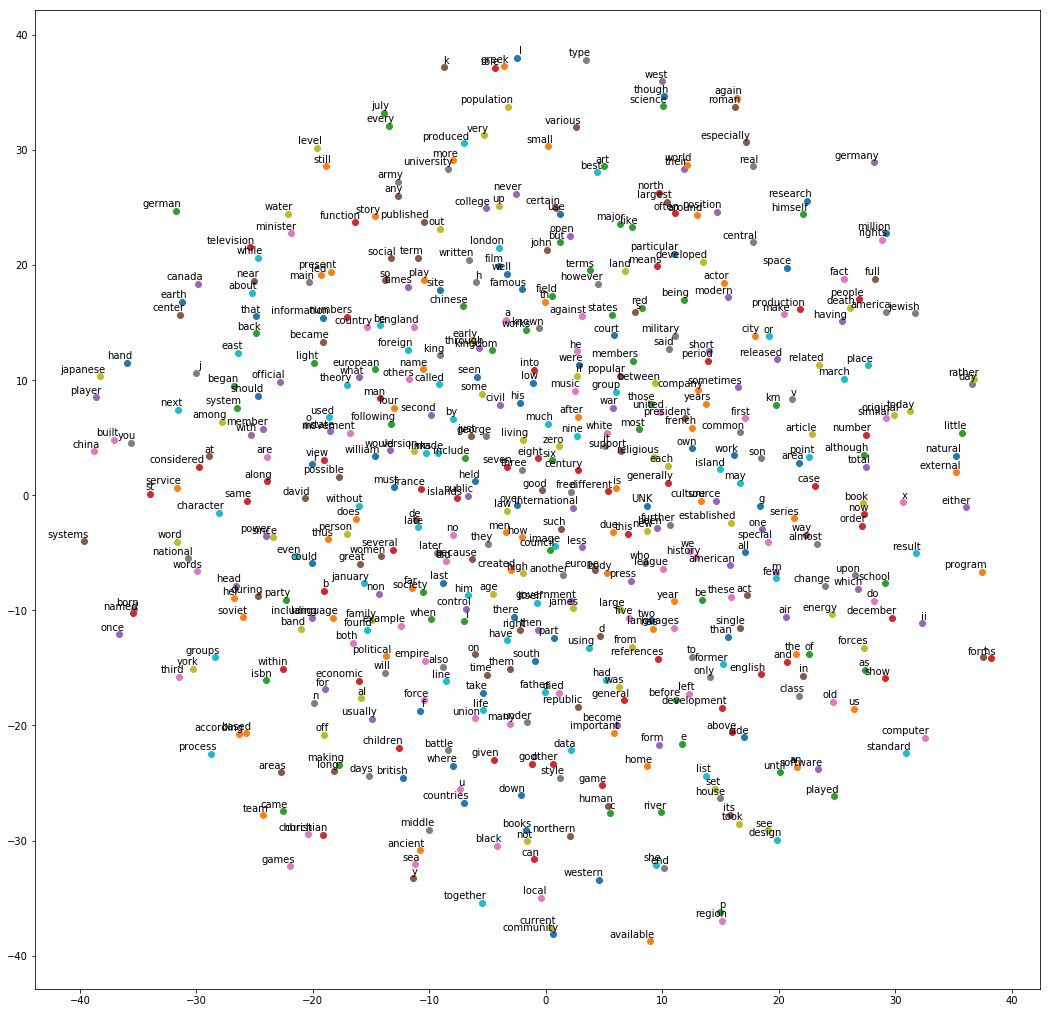

In [5]:
# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join('./', 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)